# Transpile with pass managers

The recommended way to transpile a circuit is to create a staged pass manager and then execute its `run` method with the circuit as input. This page explains how to transpile quantum circuits this way.

## What is a (staged) pass manager?

In the context of the Qiskit SDK, transpilation refers to the process of transforming an input circuit into a form that is suitable for execution on a quantum device. Transpilation typically occurs in a sequence of steps called transpiler passes. The circuit is processed by each transpiler pass in sequence, with the output of one pass becoming the input to the next. For example, one pass could go through the circuit and merge all consecutive sequences of single-qubit gates, and then the next pass could synthesize these gates into the basis set of the target device. The transpiler passes included with Qiskit are located in the [qiskit.transpiler.passes](/api/qiskit/transpiler_passes) module.

A pass manager is an object that stores a list of transpiler passes and can execute them on a circuit. Create a pass manager by initializing a [`PassManager`](/api/qiskit/qiskit.transpiler.PassManager) with a list of transpiler passes. To run the transpilation on a circuit, call the [`run`](/api/qiskit/qiskit.transpiler.PassManager#run) method with a circuit as input.

A staged pass manager is a special kind of pass manager that represents a level of abstraction above that of a normal pass manager. While a normal pass manager is composed of several transpiler passes, a staged pass manager is composed of several *pass managers*. This is a useful abstraction because transpilation typically happens in discrete stages, as described in [Transpiler stages](transpiler-stages), with each stage being represented by a pass manager. Staged pass managers are represented by the [`StagedPassManager`](/api/qiskit/qiskit.transpiler.StagedPassManager) class. The rest of this page describes how to create and customize (staged) pass managers.

## Generate a preset staged pass manager

To create a preset staged pass manager with reasonable defaults, use the [`generate_preset_pass_manager`](/api/qiskit/transpiler_preset#qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager) function:

In [1]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

To transpile a circuit or list of circuits with a pass manager, pass the circuit or list of circuits to the `run` method. Let's do this on a two-qubit circuit consisting of a Hadamard followed by two adjacent CX gates:

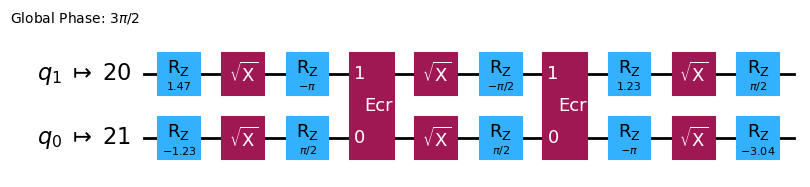

In [2]:
from qiskit import QuantumRegister, QuantumCircuit

# Create a circuit
qubits = QuantumRegister(2, name="q")
circuit = QuantumCircuit(qubits)
a, b = qubits
circuit.h(a)
circuit.cx(a, b)
circuit.cx(b, a)

# Transpile it by calling the run method of the pass manager
transpiled = pass_manager.run(circuit)

# Draw it, excluding idle qubits from the diagram
transpiled.draw("mpl", idle_wires=False)

See [Transpilation defaults and configuration options](defaults-and-configuration-options) for a description of the possible arguments to the `generate_preset_pass_manager` function. The arguments to `generate_preset_pass_manager` match the arguments to the [`transpile`](/api/qiskit/compiler#qiskit.compiler.transpile) function.

If the preset pass managers don't fulfill your needs, customize transpilation by creating (staged) pass managers or even transpilation passes. The rest of this page describes how to create pass managers. For instructions on how to create transpilation passes, see [Write your own transpiler pass](custom-transpiler-pass).

## Create your own pass manager

The [qiskit.transpiler.passes](/api/qiskit/transpiler_passes) module includes many transpiler passes that can be used to create pass managers. To create a pass manager, initialize a `PassManager` with a list of passes. For example, the following code creates a transpiler pass that merges adjacent two-qubit gates and then synthesizes them into a basis of [$R_y$](/api/qiskit/qiskit.circuit.library.RYGate), [$R_z$](/api/qiskit/qiskit.circuit.library.RZGate), and [$R_{xx}$](/api/qiskit/qiskit.circuit.library.RXXGate),  gates.

In [3]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    Collect2qBlocks,
    ConsolidateBlocks,
    UnitarySynthesis,
)

basis_gates = ["rx", "ry", "rxx"]
translate = PassManager(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates),
        UnitarySynthesis(basis_gates),
    ]
)

To demonstrate this pass manager in action, test it on a two-qubit circuit consisting of a Hadamard followed by two adjacent CX gates:

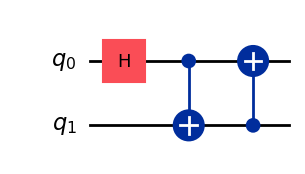

In [4]:
from qiskit import QuantumRegister, QuantumCircuit

qubits = QuantumRegister(2, name="q")
circuit = QuantumCircuit(qubits)

a, b = qubits
circuit.h(a)
circuit.cx(a, b)
circuit.cx(b, a)

circuit.draw("mpl")

To run the pass manager on the circuit, call the `run` method.

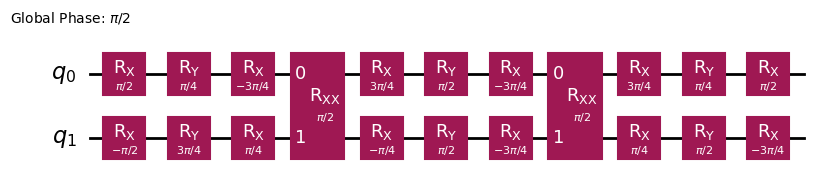

In [5]:
translated = translate.run(circuit)
translated.draw("mpl")

For a more advanced example that shows how to create a pass manager to implement the error suppression technique known as dynamical decoupling, see [Create a pass manager for dynamical decoupling](dynamical-decoupling-pass-manager).

## Create a staged pass manager

A `StagedPassManager` is a pass manager that is composed of individual stages, where each stage is defined by a `PassManager` instance. You can create a `StagedPassManager` by specifying the desired stages. For example, the following code creates a staged pass manager with two stages, `init` and `translation`. The `translation` stage is defined by the pass manager that was created previously.

In [6]:
from qiskit.transpiler import PassManager, StagedPassManager
from qiskit.transpiler.passes import UnitarySynthesis, Unroll3qOrMore

basis_gates = ["rx", "ry", "rxx"]
init = PassManager([UnitarySynthesis(basis_gates, min_qubits=3), Unroll3qOrMore()])
staged_pm = StagedPassManager(
    stages=["init", "translation"], init=init, translation=translate
)

There is no limit on the number of stages you can put in a staged pass manager.

Another useful way to create a staged pass manager is to begin with a preset staged pass manager and then swap out some of the stages. For example, the following code generates a preset pass manager with optimization level 3, and then specifies a custom `pre_layout` stage.

In [7]:
import numpy as np
from qiskit.circuit.library import HGate, PhaseGate, RXGate, TdgGate, TGate
from qiskit.transpiler.passes import CXCancellation, InverseCancellation

pass_manager = generate_preset_pass_manager(3, backend)
inverse_gate_list = [
    HGate(),
    (RXGate(np.pi / 4), RXGate(-np.pi / 4)),
    (PhaseGate(np.pi / 4), PhaseGate(-np.pi / 4)),
    (TGate(), TdgGate()),
]
logical_opt = PassManager(
    [
        CXCancellation(),
        InverseCancellation(inverse_gate_list),
    ]
)

# Add pre-layout stage to run extra logical optimization
pass_manager.pre_layout = logical_opt

The [stage generator functions](/api/qiskit/transpiler_preset#stage-generator-functions) might be useful for constructing custom pass managers.
They generate stages that provide common functionality used in many pass managers.
For example, [`generate_embed_passmanager`](/api/qiskit/transpiler_preset#qiskit.transpiler.preset_passmanagers.common.generate_embed_passmanager) can be used to generate a stage
to "embed" a selected initial `Layout` from a layout pass to the specified target device.

## Next steps

<Admonition type="tip" title="Recommendation">
    - [Write a custom transpiler pass](custom-transpiler-pass).
    - [Create a pass manager for dynamical decoupling](dynamical-decoupling-pass-manager).
    - To learn how to use the `transpile` function, start with the [Transpilation default settings and configuration options](defaults-and-configuration-options) topic.
    - Try the [Submit transpiled circuits](https://learning.quantum.ibm.com/tutorial/submit-transpiled-circuits) tutorial.
    - See the [Transpile API documentation.](https://docs.quantum-computing.ibm.com/api/qiskit/transpiler)
</Admonition>